# Código Memoria
## Autor: Cristian Navarro   Rol: 201721036-2
## Alumno de 6to Año de Ingeniería Civil Electrónica

### Desarrollo Embedding model:

In [12]:
#Imports
import pandas as pd
import numpy as np

In [13]:
Merge_Prod_Cat=pd.read_csv('Merge_Prod_Cat.csv')

In [14]:
sentences_train=pd.read_csv("sentences_train.csv").to_numpy().flatten()
sentences_test=pd.read_csv("sentences_test.csv").to_numpy().flatten()
y_train_noh=pd.read_csv("y_train_noh.csv").to_numpy().flatten()
y_test_noh=pd.read_csv("y_test_noh.csv").to_numpy().flatten()

In [15]:
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
vocab_sz = 5000
encoded_docms_train = [one_hot(st, vocab_sz) for st in sentences_train]
encoded_docms_test = [one_hot(st, vocab_sz) for st in sentences_test]

max_lenth = 30
padded_docms_train = pad_sequences(encoded_docms_train, maxlen=max_lenth, padding='post')
padded_docms_test = pad_sequences(encoded_docms_test, maxlen=max_lenth, padding='post')

In [16]:
# Applying the function to training set labels and testing set labels
from keras.utils import to_categorical
y_train = to_categorical(y_train_noh, dtype ="uint8")
y_test= to_categorical(y_test_noh, dtype ="uint8")

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense,Dropout
from tensorflow.keras import regularizers
model = Sequential()
model.add(Embedding(vocab_sz, 80, input_length=max_lenth))
model.add(Flatten())
model.add(Dense(100, activation='relu',kernel_regularizer=regularizers.L2(l2=1e-6)))
model.add(Dropout(0.4))
model.add(Dense(180, activation='softmax',activity_regularizer=regularizers.L2(1e-6)))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(padded_docms_train, y_train, epochs=10,batch_size=128 , verbose=1,validation_data=(padded_docms_test, y_test))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 80)            400000    
                                                                 
 flatten_4 (Flatten)         (None, 2400)              0         
                                                                 
 dense_8 (Dense)             (None, 100)               240100    
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 180)               18180     
                                                                 
Total params: 658,280
Trainable params: 658,280
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3709/3709 [==========================

In [18]:
model_json = model.to_json()
with open("model_embedding_final.json", "w") as json_file:
  json_file.write(model_json)
#serializan los pesos (weights) para HDF5
model.save_weights("model_embedding_final.h5")
print("Modelo guardado en el PC")

Modelo guardado en el PC


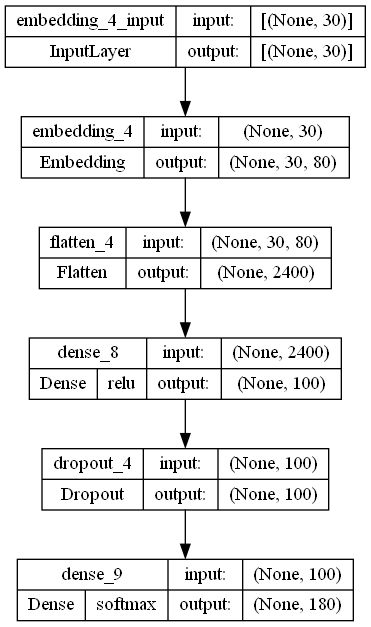

In [19]:
from keras.utils import plot_model
plot_model(model, 'RedNeu.png', show_shapes=True,show_layer_activations=True)

In [20]:
loss, accuracy = model.evaluate(padded_docms_train, y_train, verbose=False)
print("Precisión Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(padded_docms_test, y_test, verbose=False)
print("Precisión Prueba:  {:.4f}".format(accuracy))

Precisión Entrenamiento: 0.9506
Precisión Prueba:  0.8823


In [21]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') # 

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento prec')
    plt.plot(x, val_acc, 'r', label='Validacion prec')
    plt.title('Precision Entrenamiento y validacion')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Perdida Entrenamiento')
    plt.plot(x, val_loss, 'r', label='Perdida Validacion')
    plt.title('Perdida Entrenamiento y validacion')
    plt.legend()
    plt.show()

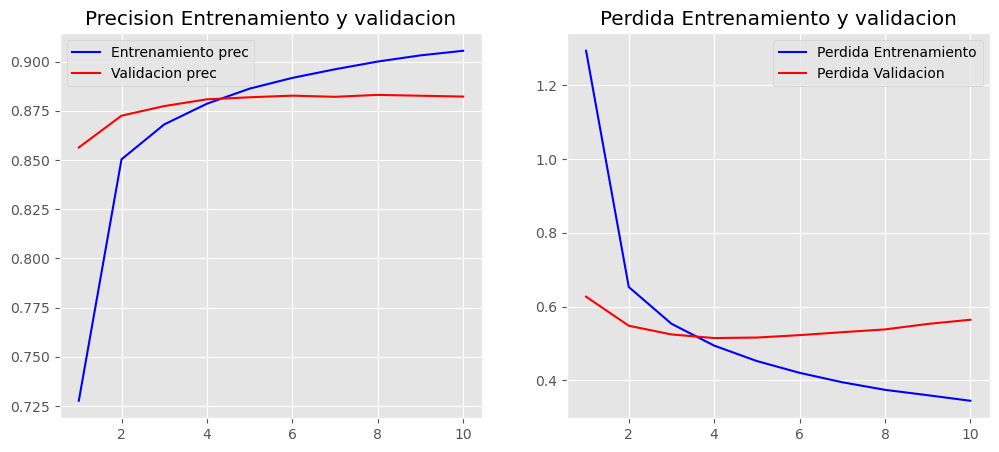

In [22]:
plot_history(history)

In [23]:
prediction = model.predict(padded_docms_test)
print("prediction shape:", prediction.shape)

6358/6358 [==============================] - 8s 1ms/step
prediction shape: (203450, 180)


In [27]:
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                             recall_score, f1_score, classification_report)

y_pred=np.argmax(prediction, axis=1)
y_val=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_val, y_pred)
print(cm)

[[ 235    3    3 ...    0    0    0]
 [   1  311    8 ...    0    0    0]
 [   1    1 4277 ...    0    0    0]
 ...
 [   0    0    0 ...   13    0    0]
 [   0    0    0 ...    0   80    0]
 [   0    0    0 ...    0    0    0]]


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    percent:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [29]:
import seaborn as sns
make_confusion_matrix(cm, figsize=(65,65),categories=Merge_Prod_Cat['idCategoria'].unique(),percent=False, cbar=False)

In [31]:
prueba=pd.DataFrame(y_test_noh)

In [32]:
for i,j in zip(range(len(cm[0])),Merge_Prod_Cat['idCategoria'].unique()):
    print("Los clasificados correctamente de la categoria "+ str(j) + " son: "+str(cm[i][i]) + " de un total de datos de: "+str(len(prueba[prueba[0]==j])) +" datos" + ". Finalmente, el porcentaje de aciertos es de "+str(round(cm[i][i]*100/len(prueba[prueba[0]==j]))) + "%")

Los clasificados correctamente de la categoria 2 son: 235 de un total de datos de: 306 datos. Finalmente, el porcentaje de aciertos es de 77%
Los clasificados correctamente de la categoria 3 son: 311 de un total de datos de: 477 datos. Finalmente, el porcentaje de aciertos es de 65%
Los clasificados correctamente de la categoria 4 son: 4277 de un total de datos de: 5188 datos. Finalmente, el porcentaje de aciertos es de 82%
Los clasificados correctamente de la categoria 5 son: 4416 de un total de datos de: 5577 datos. Finalmente, el porcentaje de aciertos es de 79%
Los clasificados correctamente de la categoria 6 son: 7939 de un total de datos de: 8655 datos. Finalmente, el porcentaje de aciertos es de 92%
Los clasificados correctamente de la categoria 7 son: 131 de un total de datos de: 176 datos. Finalmente, el porcentaje de aciertos es de 74%
Los clasificados correctamente de la categoria 8 son: 3231 de un total de datos de: 3597 datos. Finalmente, el porcentaje de aciertos es de 90